## 加载模型和数据集

In [1]:
import sys
sys.path.append('/root/MppCLIP')

In [2]:
import os
import models
import numpy as np
from tqdm import tqdm
from libcore.config import get_cfg
from pprint import pprint
import torch.cuda
import pytorch_lightning as pl
import torch.nn.functional as func
from libcore.dataset import build_dataset, build_dataloader, build_transform
from libcore.models import build_model

In [3]:
device = torch.device('cuda:0')
EPSILON = 1e-6

# CpRM

In [4]:
cfg_name = "zSyyk-202503031735-CUB-VB16-ATT_N4G4-CpRM"

In [5]:
cfg_path = '/root/autodl-tmp/ckpts/%s/train_params.json' % cfg_name
data_cfg_data_path = '/root/autodl-tmp/fine-grained-data/CUB_200_2011'
# data_cfg_data_path = '/root/autodl-tmp/fine-grained-data/Stanford_Cars'
cfg, updater = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.freeze()
pprint(cfg)

CfgNode({'DATA': CfgNode({'NAME': 'CUB', 'PATH': 'data/fine-grained-data/CUB_200_2011', 'INPUT': CfgNode({'SIZE_SCALE': (256, 256), 'SIZE_IMAGE': 224, 'TRANS_NAME': 'CoOp'}), 'DATASET': CfgNode({'CACHED': False, 'SPLIT_TRAIN': False, 'N_SPLIT': 5, 'USED_SPLIT_ID': 0, 'FEW_SHOT': CfgNode({'ENABLED': True, 'TRAIN_SHOT': 16, 'VALID_SHOT': -1})}), 'DATALOADER': CfgNode({'SAMPLER_TRAIN': 'DEFAULT', 'BATCH_SIZE': 64, 'NUM_WORKERS': 4, 'VALID_SCALE': 1.0})}), 'TRAINER': CfgNode({'MONITOR_VALUE': 'BEST_ACC', 'SYNC_BN': False, 'UNUSED_PARAMETERS': True, 'VALID_INTERVAL': 1, 'MAX_EPOCHS': 100, 'DEVICE': 'gpu', 'DEVICE_ID': (0, 1), 'RESUME': None}), 'MODEL': CfgNode({'RESUME': None, 'NET': CfgNode({'VARIANT': 'single_xpr', 'BACKBONE': CfgNode({'NAME': 'ViT-B/16', 'STRIDE_SIZE': 16, 'IMAGE_SIZE': 224, 'FEAT_DIM': 2048, 'LAST_STRIDE': 1, 'VISUAL_PROMPT': False}), 'PROMPTS': CfgNode({'TYPE': 'mp_clip', 'DATA_NAME': 'CUB', 'PARAMS': CfgNode({'N_FIX': 0, 'N_FLE': 16, 'N_SPLIT': 1, 'N_GROUP': 4, 'IMG_S

In [6]:
data_cfg = cfg.DATA
_, valid_dataset, cls_num = build_dataset(
    data_cfg.NAME.lower(), data_cfg_data_path, data_cfg.DATASET, build_transform(data_cfg.INPUT),
)
valid_dataloader = build_dataloader(valid_dataset, data_cfg.DATALOADER, shuffle=False)

-----  ----  ----
SPLIT  SHOT  NUM.
TRAIN  16    3200
VALID  -1    5794
-----  ----  ----
Class Number : 200


In [7]:
fgic_model = build_model(cfg.MODEL, cls_num)
fgic_model.load_state_dict(
    torch.load(os.path.join("/root/autodl-tmp/ckpts/", cfg['best_path'].split('/ckpts/')[1]), map_location='cpu')['state_dict'], strict=False,
)

[] ['visual.stride_size']


/tmp/ipykernel_112318/1518725167.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join("/root/autodl-tmp/ckpts/", cfg['best_path'].split('/ckpts/')[1])

_IncompatibleKeys(missing_keys=[], unexpected_keys=['network.tex_f'])

In [8]:
trainer = pl.Trainer(accelerator='gpu', devices=[0, ], num_nodes=1, max_epochs=1,)
trainer.validate(fgic_model, valid_dataloader, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA vGPU-32GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: |                                                   | 0/? [00:00<?, ?it/s]

Mar06-10:50:17 Epoch   0|  1 | Valid Loss    0.713 | L0 0.713 | A0 80.929 |Best-A 80.929


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            A-0            │    0.8092854619026184     │
│         BEST_ACC          │    0.8092854619026184     │
└───────────────────────────┴───────────────────────────┘

[{'A-0': 0.8092854619026184, 'BEST_ACC': 0.8092854619026184}]

In [15]:
net = fgic_model.network
net.to(device)
net.eval()

SingleCpRM(
  (mp_prompts): MppPrompt()
  (tex_encoder): TexEncoder(
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=512, out_features=2048, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          )
          (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            

In [16]:
tex_f = net.tex_feature()

In [17]:
img_f_list = []
cpr_f_list = []
cpr_f1_list = []
lbs_list = []
with torch.no_grad():
    for data_batch in tqdm(valid_dataloader):
        ims, lbs = data_batch
        ims, lbs = ims.to(device), lbs.to(device)
        img_f    = net.img_feature(ims)
        img_f_list.append(img_f.detach())
        
        n, cls, c = tex_f.shape
        img_f = func.normalize(img_f, dim=-1, eps=EPSILON) * net.xp_classifier.x_sf
        tex_f = func.normalize(tex_f, dim=-1, eps=EPSILON) * net.xp_classifier.x_sf
        cp_rel = torch.einsum(
            'b x c, y d c -> b yxd',
            net.xp_classifier.fc1(img_f.permute(0, 2, 1)).permute(0, 2, 1),
            net.xp_classifier.fc2(tex_f.permute(1, 2, 0)).permute(2, 0, 1),
        ).reshape(img_f.shape[0], cls, -1)
        cp_rel_1 = net.xp_classifier.prt_fc[:3](cp_rel.reshape(img_f.shape[0], -1))
        
        cpr_f_list.append(cp_rel.detach())
        cpr_f1_list.append(cp_rel_1.detach())
        lbs_list.append(lbs)

 ... (more hidden) ...


In [18]:
img_f_list = torch.cat(img_f_list, dim=0)
cpr_f_list = torch.cat(cpr_f_list, dim=0)
cpr_f1_list = torch.cat(cpr_f1_list, dim=0)
lbs_list = torch.cat(lbs_list, dim=0)

## 对提取到的特征可视化

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP

In [20]:
X = cpr_f1_list.cpu().numpy()  # 特征矩阵
y = lbs_list.cpu().numpy()  # 标签

index = y<30

# 使用t-SNE进行降维
tsne = UMAP(n_components=2, random_state=42, n_neighbors=50, min_dist=1.0)
X_embedded = tsne.fit_transform(X[index])

/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/root/miniconda3/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


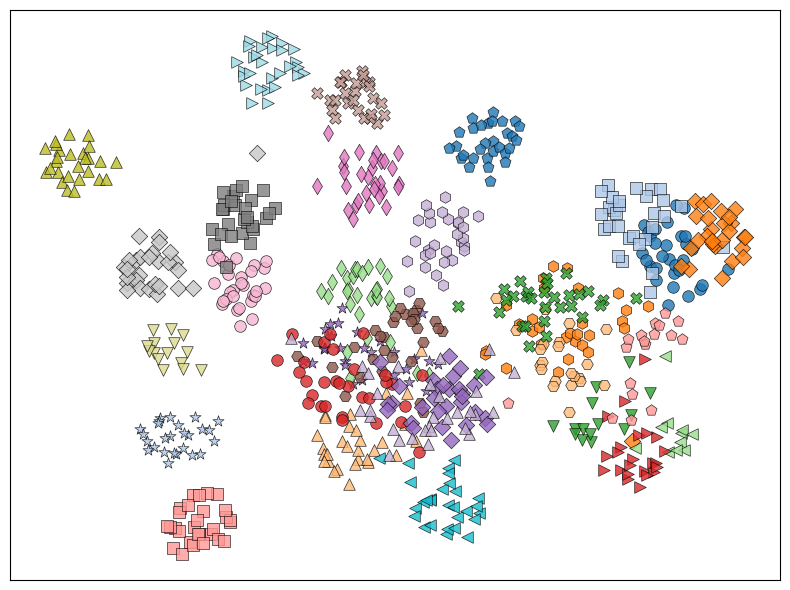

In [21]:
colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 使用 tab20 颜色映射（20 种颜色）
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'X', 'd']  # 15 种形状
plt.figure(figsize=(8, 6))
for i in range(0, 50):  # 遍历 200 个类别
    color = colors[i % len(colors)]  # 循环使用颜色
    marker = markers[i % len(markers)]  # 循环使用形状
    plt.scatter(
        X_embedded[y[index] == i, 0], 
        X_embedded[y[index] == i, 1], 
        color=color,  # 颜色
        marker=marker,  # 形状
        s=70,  # 点大小
        alpha=0.8,  # 透明度
        edgecolor='k',  # 边缘颜色
        linewidths=0.5,  # 边缘宽度
    )
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('umap-pwcs-cr-cprm.pdf', bbox_inches='tight', format='pdf')
plt.show()

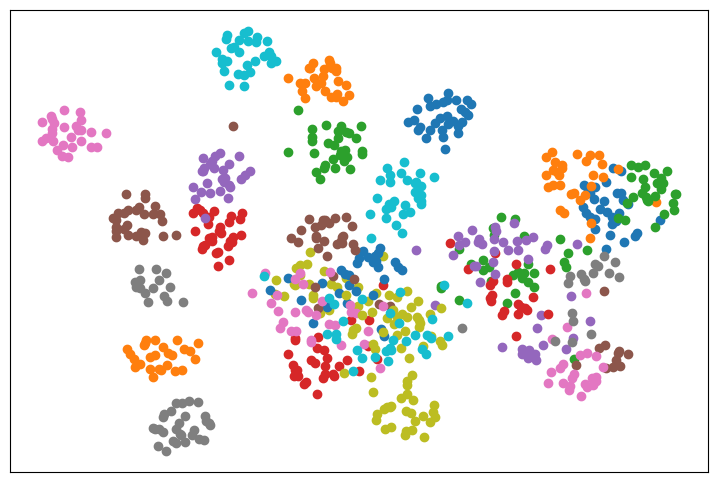

In [22]:
plt.figure(figsize=(9, 6))
for i, target_name in enumerate(torch.unique(lbs_list).cpu().numpy()):
    plt.scatter(X_embedded[y[index]==i, 0], X_embedded[y[index]==i, 1], label=target_name)
# plt.title('t-SNE visualization of Iris dataset')
plt.xticks([])
plt.yticks([])
plt.show()

In [23]:
img_f_list.shape

torch.Size([5794, 4, 512])

In [24]:
X = img_f_list.reshape(-1, 2048).cpu().numpy()  # 特征矩阵
y = lbs_list.cpu().numpy()  # 标签

index = y<30

# 使用t-SNE进行降维
tsne = UMAP(n_components=2, random_state=42, n_neighbors=50, min_dist=1.0)
X_embedded = tsne.fit_transform(X[index])

/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


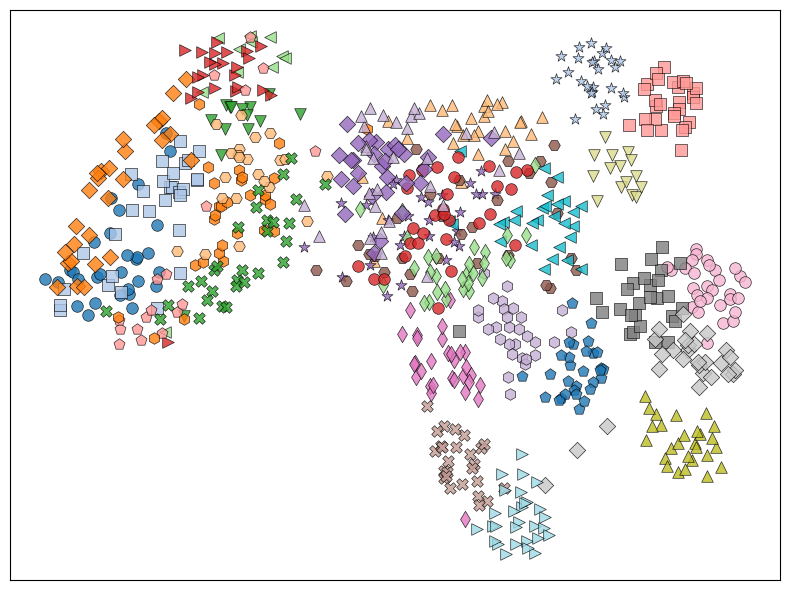

In [25]:
colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 使用 tab20 颜色映射（20 种颜色）
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'X', 'd']  # 15 种形状
plt.figure(figsize=(8, 6))
for i in range(0, 50):  # 遍历 200 个类别
    color = colors[i % len(colors)]  # 循环使用颜色
    marker = markers[i % len(markers)]  # 循环使用形状
    plt.scatter(
        X_embedded[y[index] == i, 0], 
        X_embedded[y[index] == i, 1], 
        color=color,  # 颜色
        marker=marker,  # 形状
        s=70,  # 点大小
        alpha=0.8,  # 透明度
        edgecolor='k',  # 边缘颜色
        linewidths=0.5,  # 边缘宽度
    )
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('umap-cub-vf-cprm.pdf', bbox_inches='tight', format='pdf')
plt.show()

# PwCS

In [26]:
cfg_name = "aV7FX-202503051508-CUB-VB16-ATT_N4G4-PwCS"
cfg_path = '/root/autodl-tmp/ckpts/%s/train_params.json' % cfg_name
data_cfg_data_path = '/root/autodl-tmp/fine-grained-data/CUB_200_2011'
cfg, updater = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.freeze()
pprint(cfg)

CfgNode({'DATA': CfgNode({'NAME': 'CUB', 'PATH': 'data/fine-grained-data/CUB_200_2011', 'INPUT': CfgNode({'SIZE_SCALE': (256, 256), 'SIZE_IMAGE': 224, 'TRANS_NAME': 'CoOp'}), 'DATASET': CfgNode({'CACHED': False, 'SPLIT_TRAIN': False, 'N_SPLIT': 5, 'USED_SPLIT_ID': 0, 'FEW_SHOT': CfgNode({'ENABLED': True, 'TRAIN_SHOT': 16, 'VALID_SHOT': -1})}), 'DATALOADER': CfgNode({'SAMPLER_TRAIN': 'DEFAULT', 'BATCH_SIZE': 64, 'NUM_WORKERS': 4, 'VALID_SCALE': 1.0})}), 'TRAINER': CfgNode({'MONITOR_VALUE': 'BEST_ACC', 'SYNC_BN': False, 'UNUSED_PARAMETERS': True, 'VALID_INTERVAL': 1, 'MAX_EPOCHS': 100, 'DEVICE': 'gpu', 'DEVICE_ID': (0, 1), 'RESUME': None}), 'MODEL': CfgNode({'RESUME': None, 'NET': CfgNode({'VARIANT': 'single_sim', 'BACKBONE': CfgNode({'NAME': 'ViT-B/16', 'STRIDE_SIZE': 16, 'IMAGE_SIZE': 224, 'FEAT_DIM': 2048, 'LAST_STRIDE': 1, 'VISUAL_PROMPT': False}), 'PROMPTS': CfgNode({'TYPE': 'mp_clip', 'DATA_NAME': 'CUB', 'PARAMS': CfgNode({'N_FIX': 0, 'N_FLE': 16, 'N_SPLIT': 1, 'N_GROUP': 4, 'IMG_S

In [27]:
data_cfg = cfg.DATA
_, valid_dataset, cls_num = build_dataset(
    data_cfg.NAME.lower(), data_cfg_data_path, data_cfg.DATASET, build_transform(data_cfg.INPUT),
)
valid_dataloader = build_dataloader(valid_dataset, data_cfg.DATALOADER, shuffle=False)
fgic_model = build_model(cfg.MODEL, cls_num)
fgic_model.load_state_dict(
    torch.load(os.path.join("/root/autodl-tmp/ckpts/", cfg['best_path'].split('/ckpts/')[1]), map_location='cpu')[
        'state_dict'], strict=False,
)

-----  ----  ----
SPLIT  SHOT  NUM.
TRAIN  16    3200
VALID  -1    5794
-----  ----  ----
Class Number : 200
[] ['visual.stride_size']


/tmp/ipykernel_112318/1065971231.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join("/root/autodl-tmp/ckpts/", cfg['best_path'].split('/ckpts/')[1])

<All keys matched successfully>

In [28]:
trainer = pl.Trainer(accelerator='gpu', devices=[0, ], num_nodes=1, max_epochs=1,)
trainer.validate(fgic_model, valid_dataloader, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: |                                                   | 0/? [00:00<?, ?it/s]

Mar06-11:07:53 Epoch   0|  1 | Valid Loss    0.845 | L0 0.845 | A0 77.149 |Best-A 77.149


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            A-0            │    0.7714877724647522     │
│         BEST_ACC          │    0.7714877724647522     │
└───────────────────────────┴───────────────────────────┘

[{'A-0': 0.7714877724647522, 'BEST_ACC': 0.7714877724647522}]

In [29]:
net = fgic_model.network
net.to(device)
net.eval()
tex_f = net.tex_feature()

In [30]:
img_f_list = []
lbs_list = []
with torch.no_grad():
    for data_batch in tqdm(valid_dataloader):
        ims, lbs = data_batch
        ims, lbs = ims.to(device), lbs.to(device)
        img_f    = net.img_feature(ims)
        img_f_list.append(img_f.detach())
        lbs_list.append(lbs)

 ... (more hidden) ...


In [31]:
img_f_list = torch.cat(img_f_list, dim=0)
lbs_list = torch.cat(lbs_list, dim=0)

/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


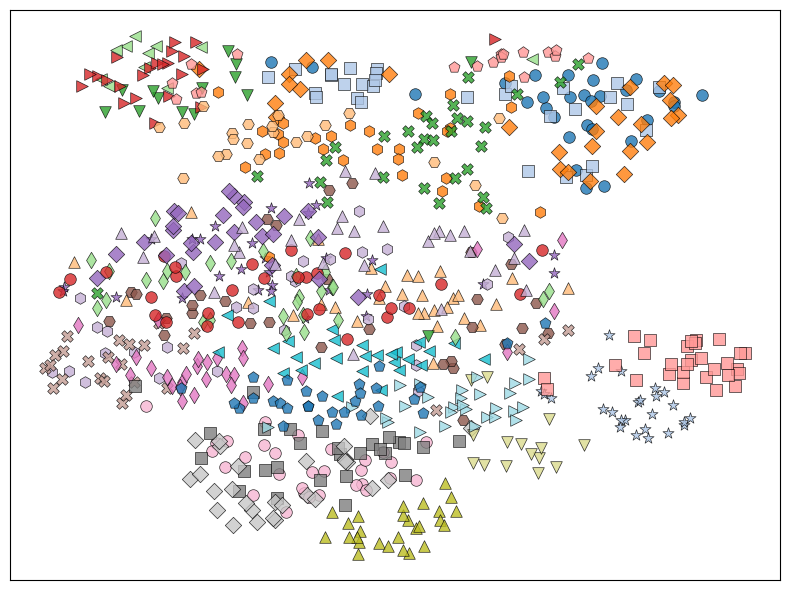

In [32]:
X = img_f_list.reshape(-1, 2048).cpu().numpy()  # 特征矩阵
y = lbs_list.cpu().numpy()  # 标签

index = y < 30

# 使用t-SNE进行降维
tsne = UMAP(n_components=2, random_state=42, n_neighbors=50, min_dist=1.0)
X_embedded = tsne.fit_transform(X[index])
colors = plt.cm.tab20(np.linspace(0, 1, 20))  # 使用 tab20 颜色映射（20 种颜色）
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'X', 'd']  # 15 种形状
plt.figure(figsize=(8, 6))
for i in range(0, 50):  # 遍历 200 个类别
    color = colors[i % len(colors)]  # 循环使用颜色
    marker = markers[i % len(markers)]  # 循环使用形状
    plt.scatter(
        X_embedded[y[index] == i, 0],
        X_embedded[y[index] == i, 1],
        color=color,  # 颜色
        marker=marker,  # 形状
        s=70,  # 点大小
        alpha=0.8,  # 透明度
        edgecolor='k',  # 边缘颜色
        linewidths=0.5,  # 边缘宽度
    )
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('umap-pwcs-cub.pdf', bbox_inches='tight', format='pdf')
plt.show()